In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

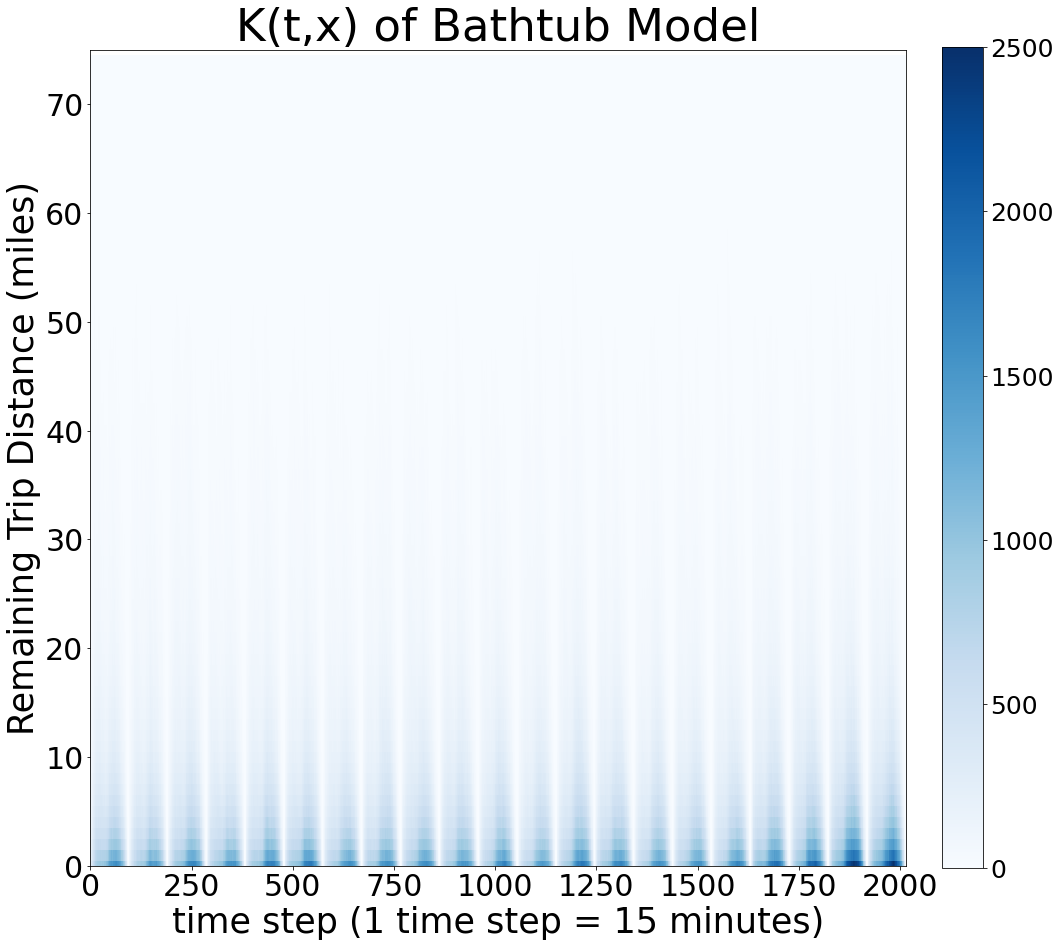

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 3 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  25200
N_u =  5040
N_f =  10080


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

In [9]:
X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04054054, 0.04054054, 0.04054054, ..., 0.04054054, 0.04054054,
        0.04054054],
       [0.08108108, 0.08108108, 0.08108108, ..., 0.08108108, 0.08108108,
        0.08108108],
       ...,
       [0.89189189, 0.89189189, 0.89189189, ..., 0.89189189, 0.89189189,
        0.89189189],
       [0.93243243, 0.93243243, 0.93243243, ..., 0.93243243, 0.93243243,
        0.93243243],
       [0.97297297, 0.97297297, 0.97297297, ..., 0.97297297, 0.97297297,
        0.97297297]])

In [10]:
T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)]

array([[0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       ...,
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01]])

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [11]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [12]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [13]:
X_u_train.shape

(5040, 2)

In [14]:
X_u_test.shape

(20160, 2)

In [15]:
X_u_train

array([[0.36486486, 0.12704715],
       [0.72972973, 0.41588089],
       [0.44594595, 0.97270471],
       ...,
       [0.72972973, 0.39801489],
       [0.64864865, 0.14094293],
       [0.97297297, 0.81488834]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [16]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [ ]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0044341959628528558 0.0081069663445699526 0.00076142558113575967 0.8030252939018767
0.0043677160830557244 0.0080707697257705671 0.00066466244034088084 0.8016789250990877
0.0043037693739778095 0.0080189260834207434 0.000588612664534875 0.7996702785382325
0.0042233990826585771 0.0078874259170388077 0.00055937224827834714 0.7938143912561568
0.0040697988377742618 0.0075886592778242491 0.00055093839772427425 0.7799730046264917
0.0039479535956182133 0.0073916213984778741 0.00050428579275855188 0.7703914679034483
0.0039156164893516037 0.0073568367086182954 0.00047439627008491133 0.7685161218982857
0.0039007162865160243 0.00735193094868188 0.00044950162435016818 0.768189481783238
0.0038718255669811948 0.0073515798204093329 0.00039207131355305659 0.7681042739311665
0.0038420934159524656 0.0073468730372950909 0.00033731379460983984 0.7679699155595406
0.0038227609850435382 0.00732868860347003 0.00031683336661704654 0.7672684926454268
0.0038139916811897896 0.0073216700746666251 0.000306313287712

0.0024450806298960035 0.0042083781942544125 0.00068178306553759471 0.5913964137963075
0.0024436463281500525 0.0041836351460297783 0.00070365751027032654 0.5898232459151379
0.0024434304411879619 0.004186078611645082 0.0007007822707308422 0.589938514240848
0.0024410420740935742 0.0041858425090598571 0.00069624163912729146 0.5898443709191334
0.0024403234837779525 0.0041828475349852748 0.00069779943257063006 0.5896160375039682
0.0024399972957068672 0.0041728142391727185 0.00070718035224101561 0.5889033610495433
0.0024397614221379265 0.00416872668456419 0.00071079615971166314 0.5885742897309892
0.0024392757271184708 0.00417173907671239 0.00070681237752455146 0.588797560438951
0.0024389292592706885 0.004178200478062527 0.00069965804047884958 0.5892444364670715
0.0024379407444930605 0.0041808398100808448 0.00069504167890527583 0.5894477581970233
0.0024371092055357041 0.0041787688701325817 0.00069544954093882694 0.5892521575212227
0.0024366367028817774 0.0041705364924003469 0.00070273691336320

0.0024190502009031403 0.0041231525577676729 0.00071494784403860806 0.5857541601796726
0.002418938606370432 0.0041187313544150013 0.0007191458583258631 0.5854748336999449
0.00241887084619505 0.004118912248017634 0.00071882944437246616 0.5855081762050963
0.0024188588136869566 0.0041219641704528078 0.000715753456921106 0.5857071873086768
0.0024188368197434161 0.0041190030634129663 0.00071867057607386594 0.5855269920684327
0.0024188256242950578 0.0041188778802448847 0.00071877336834523064 0.5855251657854027
0.0024188107175941273 0.00411995114338455 0.00071767029180370458 0.5855924411033678
0.0024187841670536385 0.0041204986284123866 0.00071706970569489 0.5856321998656081
0.0024187383770827155 0.0041202641742782648 0.0007172125798871659 0.5856208466534636
0.0024186725587486716 0.004119455898254379 0.00071788921924296426 0.585576289874249
0.0024185304239753786 0.0041171046415065544 0.0007199562064442031 0.5854420461246929
0.0024183657406061073 0.004112306699378546 0.00072442478183366843 0.58

0.0024027237584000861 0.0041114076217097359 0.00069403989509043615 0.5858500275026862
0.0024026306680776646 0.0041114869734239032 0.000693774362731426 0.5858636287430937
0.002402417505517414 0.0041139398588442 0.00069089515219062758 0.5860621003764261
0.0024023276756152917 0.0041112961028778525 0.000693359248352731 0.5859580097155103
0.0024022394944005587 0.0041222034159547494 0.00068227557284636776 0.5866884308933409
0.00240219855876897 0.0041188845173363766 0.00068551260020156325 0.5864905613285316
0.0024021599328382451 0.0041074946197043084 0.00069682524597218141 0.585739873513973
0.002402050065562383 0.0041131877814936917 0.00069091234963107454 0.5861153451161973
0.0024019880925677125 0.0041166658713564655 0.00068731031377895963 0.5863540845502583
0.00240191682790952 0.004118011031211447 0.00068582262460759285 0.5864801908642706
0.0024017289178318146 0.0041181974321221051 0.00068526040354152423 0.5864993411513554
0.0024015001870466689 0.0041146512774453631 0.0006883490966479751 0.5

0.0023940147515076429 0.0040928096279389562 0.00069521987507632982 0.585135540778328
0.0023940121257250485 0.0040925739448664181 0.00069545030658367914 0.5851163318412841
0.0023940003700215684 0.0040918604913060246 0.00069614024873711244 0.5850502210281388
0.0023939875869608842 0.004091432638144636 0.00069654253577713216 0.5850073442234451
0.0023939696160986709 0.004090785472391844 0.00069715375980549754 0.5849608443966205
0.0023939650865934426 0.0040919197071360774 0.000696010466050808 0.5850417581301077
0.0023939604295360748 0.0040917215567880163 0.00069619930228413359 0.5850480392513462
0.0023939474934520167 0.0040922659022087776 0.0006956290846952556 0.5850869136417752
0.0023939428627422674 0.0040919883287295821 0.000695897396754953 0.5850698183770725
0.0023939349590095305 0.0040919563745594745 0.0006959135434595863 0.5850767856171208
0.0023939307312258215 0.0040914725952647876 0.00069638886718685557 0.5850430454094099
0.0023939262251056873 0.0040911218746356361 0.00069673057557573

0.0023930617851552378 0.0040829178850148281 0.00070320568529564764 0.58439015746308
0.0023930603912655215 0.00408296768989237 0.000703153092638673 0.5843910910599058
0.0023930596285930863 0.0040825489099146654 0.00070357034727150717 0.5843624627447344
0.0023930582804461689 0.0040829997104515642 0.00070311685044077373 0.5843891457123553
0.0023930560876570697 0.0040832069120080011 0.000702905263306138 0.5844004507256472
0.0023930487787232804 0.00408366472929972 0.00070243282814684072 0.5844251259787653
0.002393043652429322 0.0040839240451177265 0.00070216325974091726 0.5844406049114741
0.0023930345896302409 0.0040844416660392718 0.00070162751322121034 0.5844734191496661
0.0023930248941116342 0.0040868746117704129 0.0006991751764528556 0.5846254168909469
0.0023929920796552785 0.0040877569847779906 0.0006982271745325664 0.584666647490085
0.0023929536789452613 0.004088982200696774 0.00069692515719374894 0.5847328109647467
0.002392913385385042 0.0040905000780108031 0.000695326692759281 0.584

0.0023915912229774505 0.0040816918584397 0.00070149058751520135 0.5842896442297655
0.0023915792112179095 0.00408248106813215 0.00070067735430366911 0.584330687439283
0.0023915754563929525 0.0040817655928077146 0.00070138531997819 0.5842848121810209
0.0023915717875720166 0.0040810554750168636 0.00070208810012716949 0.5842311077554696
0.0023915680129238124 0.004081645765434027 0.00070149026041359806 0.5842664383823813
0.0023915656889449714 0.004081842042091245 0.00070128933579869767 0.5842828981370507
0.0023915597864088466 0.0040818809714297678 0.00070123860138792576 0.5842922492398511
0.0023915584382790287 0.0040834468678634739 0.000699670008694584 0.5843980634514392
0.0023915539931986746 0.0040820378571662782 0.00070107012923107054 0.5843116207986282
0.0023915510178228686 0.0040816402569088233 0.000701461778736914 0.5842824998923546
0.0023915447118852849 0.00408190323824558 0.00070118618552498981 0.5842984905407204
0.0023915422685848254 0.0040815057526408247 0.00070157878452882614 0.58

0.0023905986097708075 0.0040812220139046246 0.00069997520563699065 0.5843256328414371
0.0023905866826285757 0.0040811305344745624 0.000700042830782589 0.5843109092127576
0.00239057237454628 0.0040792993193521556 0.00070184542974040384 0.584191559759567
0.0023905649211118634 0.0040802970567125263 0.00070083278551120033 0.5842300428988951
0.0023905545947482958 0.0040812491035486231 0.00069986008594796843 0.5842977523056593
0.0023905495131178343 0.0040809948826521936 0.00070010414358347487 0.5842842476979778
0.0023905405145070858 0.00408129538557324 0.000699785643440931 0.5843037691077205
0.0023905341072606679 0.0040798378581290559 0.00070123035639228022 0.5842007614888123
0.0023905230069142967 0.0040811846900515062 0.00069986132377708725 0.5842865574561107
0.0023905152583020345 0.004080935365505951 0.0007000951510981176 0.5842675277868492
0.0023905054580751562 0.0040808449689159762 0.00070016594723433566 0.5842656675985866
0.0023904955993673434 0.0040804442428585136 0.000700546955876173 

0.0023838146720851659 0.0040714143750078769 0.000696214969162455 0.5835261525259864
0.002383667999825154 0.0040711598179655915 0.00069617618168471671 0.5835340807232177
0.0023834794447147975 0.0040729224446773155 0.00069403644475227958 0.5836587420612653
0.0023832239838334048 0.0040772794298151588 0.00068916853785165111 0.5839888364360711
0.0023826956437709356 0.00407258406560415 0.00069280722193772106 0.5835927570026754
0.0023824386841150044 0.0040791566559368192 0.0006857207122931894 0.5840463750496009
0.00238213613024685 0.0040850587850238245 0.00067921347546987562 0.5844356755820216
0.0023819005031365361 0.0040848495435598783 0.000678951462713194 0.5845002914800428
0.0023814662995317384 0.0040669780439706645 0.00069595455509281225 0.5833905380823909
0.0023808895090192158 0.0040735167227836247 0.00068826229525480729 0.5838353993114479
0.0023806027104092044 0.004067238566063518 0.00069396685475489074 0.5834315583177356
0.0023798779287375832 0.0040708560201352315 0.0006888998373399346

0.0023182629912409138 0.0039887729448892 0.00064775303759262773 0.5782337427309994
0.0023181112856129962 0.00398877157486172 0.00064745099636427216 0.578242709384289
0.00231795819235906 0.0039869099366996886 0.00064900644801843142 0.5781768423911758
0.0023178109700795579 0.0039843164177495094 0.00065130552240960616 0.5780277167368817
0.0023177187909292594 0.0039829313360512661 0.00065250624580725234 0.5779553771699392
0.0023176431547717912 0.0039820692407421549 0.00065321706880142787 0.5778695685260461
0.0023175414846404508 0.0039821592417179121 0.00065292372756298926 0.5778176611299577
0.0023173704943586257 0.0039813353258705613 0.00065340566284669032 0.5777166198255242
0.0023169089884858985 0.0039798154159275878 0.00065400256104420967 0.577536578024796
0.0023164465415465348 0.0039754437177666538 0.00065744936532641555 0.5771551521202561
0.0023161095713215654 0.0039710415068106861 0.000661177635832445 0.5768480059169229
0.0023158271380736861 0.0039675441638527273 0.0006641101122946445

0.002301122665713284 0.0039452923203169392 0.00065695301110962933 0.575211821248421
0.0023010471994756782 0.0039446956471109445 0.00065739875184041188 0.5751768899544301
0.0023009244002033784 0.0039449973676620887 0.00065685143274466862 0.5752048271785909
0.0023008067953038821 0.0039425140550555472 0.00065909953555221684 0.5750360963311469
0.002300702173299014 0.0039387304367537439 0.00066267390984428359 0.5747554916061088
0.0023005988320809459 0.0039368702696291908 0.00066432739453270082 0.5745849535364702
0.0023005033049157391 0.0039369752051233824 0.00066403140470809618 0.5745485949838669
0.0023004335807510182 0.0039383438534611095 0.0006625233080409269 0.5746222417914869
0.0023003787438726467 0.0039409199045524878 0.00065983758319280539 0.5747865968436714
0.0023002797155497038 0.0039400077988887439 0.00066055163221066338 0.574736886938875
0.002300173524084364 0.003939533848378354 0.00066081319979037381 0.5747545542738124
0.002300138398165149 0.0039390939711991795 0.0006611828251311

0.0022934039330317086 0.0039348296007348281 0.000651978265328589 0.5748892271862005
0.0022933708346201632 0.0039345673599266891 0.00065217430931363736 0.5748809913168633
0.0022933531578916556 0.0039341421003198677 0.00065256421546344364 0.5748698028784706
0.002293336357725283 0.0039349726539712982 0.000651700061479268 0.5749390433461536
0.0022933185458860771 0.003934951372141662 0.00065168571963049218 0.5749447088788523
0.002293290285482984 0.0039359407076269342 0.00065063986333903389 0.5750339513542853
0.0022932614097260695 0.0039358632567472168 0.00065065956270492231 0.5750390287518291
0.0022932357882285525 0.0039374701660314856 0.00064900141042561923 0.5751549176138656
0.00229321497119897 0.003936330212620181 0.00065009972977775831 0.575079957365079
0.0022931903257433273 0.0039363617876429875 0.00065001886384366688 0.5750765923389858
0.00229315063316189 0.0039372925820224522 0.00064900868430132781 0.5751271901470959
0.0022931135223296308 0.0039363261361202674 0.00064990090853899384 

0.0022894897267434666 0.0039316682008651554 0.00064731125262177769 0.5745825689300832
0.0022894851975370761 0.00393186168523923 0.00064710870983492193 0.5745926115591271
0.0022894820746128448 0.0039315075168678193 0.0006474566323578702 0.5745722287723888
0.0022894784668765229 0.0039311558338879782 0.00064780109986506721 0.5745472000933736
0.0022894743611600018 0.0039314376416675328 0.0006475110806524703 0.5745617539358739
0.0022894712392223472 0.0039309522437698833 0.00064799023467481125 0.574528078945108
0.0022894676784447616 0.0039308245659254977 0.00064811079096402532 0.574523645291753
0.0022894651464583269 0.0039314280320238131 0.00064750226089284053 0.5745683404793495
0.0022894636702426442 0.0039312590597709489 0.00064766828071433937 0.5745551741070657
0.0022894618975988906 0.0039312462803578882 0.00064767751483989265 0.5745558026397019
0.0022894597410255675 0.0039314294726677836 0.00064749000938335132 0.5745685155906277
0.0022894575414081244 0.0039314905441169773 0.00064742453869

0.0022868005165446533 0.0039260603635726046 0.00064754066951670211 0.574227992431651
0.0022867936392108631 0.0039263863827754325 0.00064720089564629369 0.5742470135368256
0.0022867881073531621 0.0039265307852190514 0.00064704542948727307 0.5742559251001799
0.0022867745737791033 0.0039266502960475045 0.00064689885151070214 0.5742712970372801
0.0022867622596699677 0.0039269923144280312 0.00064653220491190419 0.5742879847396282
0.0022867484038712488 0.0039270710382033015 0.000646425769539196 0.5742915732496384
0.0022867400462422043 0.0039270308860131159 0.00064644920647129308 0.5742880741753242
0.0022867328245136471 0.0039268031828915209 0.00064666246613577375 0.5742696419351819
0.0022867257399564441 0.0039258408267100536 0.00064761065320283466 0.574202545539417
0.0022867213674480826 0.0039256683842123739 0.00064777435068379119 0.5741922175502419
0.0022867175414440157 0.0039256362695896446 0.00064779881329838686 0.5741915252709553
0.0022867134522984232 0.0039259554130626978 0.000647471491

0.0022846852870890568 0.0039219055611134116 0.000647465013064702 0.5741212269403237
0.0022846343184996947 0.0039222558663392177 0.00064701277066017183 0.5741111626258985
0.0022846071067020635 0.003926098267988805 0.00064311594541532186 0.5743730827570346
0.0022845460609950286 0.003924214188488471 0.00064487793350158579 0.5742204242876956
0.0022845058161024947 0.0039218158354591241 0.000647195796745865 0.5740845069064572
0.0022844512246131114 0.003921462420191946 0.00064744002903427682 0.5740796230084412
0.002284406226679699 0.0039219249218655061 0.00064688753149389161 0.5741133797336113
0.0022843660109400569 0.0039215676893421267 0.00064716433253798737 0.574060764961515
0.0022843244218198485 0.0039214876055004861 0.00064716123813921087 0.574054104519092
0.0022842853089110218 0.00392099486092963 0.00064757575689241317 0.5740080557921277
0.0022842508187104404 0.003920712601919769 0.000647789035501112 0.5739842019331385
0.0022842120458457368 0.00392057272297204 0.00064785136871943439 0.57

0.00228176381864357 0.003919089895052119 0.00064443774223502115 0.5736248129641176
0.0022817514042382842 0.00391899373889512 0.000644509069581448 0.573618743462947
0.0022817406556835968 0.0039192050928618539 0.00064427621850534007 0.5736364999501452
0.0022817326143433781 0.0039192285286712512 0.00064423670001550548 0.5736481974003936
0.00228171878400427 0.0039195820930371912 0.0006438554749713495 0.5736761625852991
0.0022817112446492718 0.0039200492631730746 0.00064337322612546875 0.573712139640123
0.0022817034990244927 0.0039200754670914812 0.00064333153095750444 0.5737162028634772
0.0022817000743467876 0.00392041497558004 0.00064298517311353566 0.5737359970316918
0.0022816976329560036 0.0039205719034839928 0.00064282336242801462 0.5737457689200695
0.0022816936655492715 0.0039206552901776687 0.00064273204092087414 0.5737498890089003
0.0022816874908598486 0.0039206530598805012 0.00064272192183919565 0.5737474492797596
0.0022816793268332085 0.0039203125351856835 0.00064304611848073367 0

0.0022796691327772321 0.0039112892235786878 0.0006480490419757763 0.5729912022320804
0.0022796506443788236 0.0039117892561138807 0.00064751203264376621 0.5730158927120348
0.0022796264093835456 0.0039111214921101938 0.00064813132665689764 0.5729599110057014
0.0022796063263542197 0.0039110467706595714 0.00064816588204886822 0.5729624274914821
0.0022795901234213579 0.0039099718389995677 0.00064920840784314854 0.5728794149834248
0.0022795869340035677 0.0039095016420454881 0.00064967222596164741 0.572839094962227
0.0022795684582874276 0.0039103864574700992 0.00064875045910475575 0.5728938556573291
0.0022795573584856923 0.0039113379426009487 0.000647776774370436 0.572955281032991
0.0022795354347151181 0.0039104805126508558 0.00064859035677938088 0.5728977306204527
0.0022795093925718607 0.00391144354424968 0.00064757524089404143 0.5729576264385953
0.002279478222146965 0.0039113832975347877 0.00064757314675914241 0.5729525748502996
0.0022794254698548593 0.0039115430981033206 0.0006473078416063

0.0022765038321876548 0.0039031090194857582 0.0006498986448895518 0.5723500249442205
0.0022764207571018429 0.0039023095552863031 0.00065053195891738255 0.5722891261826705
0.0022763619276297111 0.0039017567579326582 0.00065096709732676418 0.5722645941711605
0.0022763152967391533 0.003898175313526923 0.00065445527995138355 0.5720266859725841
0.0022762391592409652 0.0039002833780612681 0.0006521949404206625 0.5721633863774414
0.0022762100361586315 0.003901310782312662 0.00065110929000460082 0.5722113426130782
0.002276185157698713 0.0039009888414829703 0.000651381473914456 0.5721979126118778
0.0022761731928361141 0.0038995236799766447 0.00065282270569558341 0.5720876729458693
0.0022761574656706461 0.0038999552303078341 0.00065235970103345853 0.572112697322685
0.0022761398976297326 0.0039002046343516407 0.00065207516090782418 0.5721318312961639
0.0022761257453239453 0.0038999354433323155 0.00065231604731557464 0.5721114796008447
0.0022761155000638089 0.0038989145250770004 0.0006533164750506

0.0022718385136029609 0.0038835437428220727 0.000660133284383849 0.5705941040176791
0.0022717588477384519 0.0038845122020882304 0.00065900549338867307 0.5706500546729673
0.0022717073184629639 0.0038836243877642574 0.0006597902491616703 0.5705452537333037
0.0022716559143124934 0.0038816432419121753 0.00066166858671281149 0.5704146764684654
0.0022716325408938002 0.0038807332584263987 0.00066253182336120187 0.570351250103681
0.0022716121895798138 0.0038802151768012917 0.00066300920235833592 0.5703405878283209
0.0022715698749337558 0.0038799405752799614 0.0006631991745875501 0.5703235885363773
0.0022715045578422478 0.0038795302867471204 0.00066347882893737534 0.5703012962522052
0.0022714532892414503 0.0038801475647683692 0.00066275901371453164 0.570357987972548
0.0022714186825119466 0.003878950047258474 0.00066388731776541939 0.5702657540207043
0.0022713804805499292 0.0038791439349664517 0.00066361702613340677 0.5702943376855008
0.0022713551162011586 0.0038795730757660491 0.000663137156636

0.0022682653210301567 0.0038762566402270257 0.00066027400183328773 0.5701067547570196
0.0022682396694287473 0.0038756882321483868 0.00066079110670910768 0.5700627072754942
0.0022682115907934576 0.0038757638659072625 0.0006606593156796522 0.570048514952931
0.0022681857469207937 0.0038754796261151383 0.00066089186772644889 0.5700201789156905
0.0022681351036575792 0.0038747010266198859 0.00066156918069527209 0.5699431336163406
0.0022680667517683151 0.0038752122872564724 0.000660921216280158 0.5699810883655314
0.0022679949911042236 0.0038736856571172113 0.00066230432509123611 0.5698927020779757
0.0022679560388242392 0.0038729121541962574 0.00066299992345222121 0.5698861175352683
0.0022679485188710873 0.0038741749753039537 0.00066172206243822126 0.569940478692524
0.0022678143750587626 0.0038731862894509006 0.00066244246066662438 0.569868255752571
0.0022677658607554545 0.0038722356390086185 0.00066329608250229055 0.5698186324516143
0.0022677203598615182 0.0038701583348552887 0.00066528238486

0.0022609019341303278 0.0038462633220845348 0.0006755405461761208 0.5679332479234427
0.0022608352625326758 0.00384557430031229 0.00067609622475306148 0.5678858997732102
0.0022607843527931667 0.0038444349051505659 0.0006771338004357677 0.567798429398115
0.0022607577695965687 0.0038440597422086144 0.00067745579698452328 0.5677718915995884
0.0022607254425844213 0.0038434155532610418 0.00067803533190780117 0.5677143856857109
0.0022606835578283589 0.0038428485444825158 0.000678518571174202 0.5676558298234932
0.0022606518959233154 0.003842018300060702 0.00067928549178592878 0.5675813100632261
0.0022605853498397586 0.0038391255681803028 0.00068204513149921413 0.5673353342621705
0.0022604817628197223 0.0038361170695848058 0.00068484645605463863 0.5670524335003462
0.0022604752730253238 0.0038367817447672154 0.00068416880128343194 0.5670915092603269
0.0022603846875168549 0.0038350496800735462 0.00068571969496016407 0.5669400710650272
0.0022603451149624814 0.00383524735245371 0.000685442877471253

0.0022283294036668658 0.0036927792461931069 0.00076387956114062428 0.5523352304802308
0.0022280246234812873 0.0036863442086739169 0.00076970503828865781 0.5518381735810333
0.0022278211855619825 0.0036833074330270316 0.00077233493809693342 0.5516193461926944
0.0022274707863611507 0.0036795368261463976 0.00077540474657590423 0.5513748658102696
0.0022273639702684641 0.0036795036551816691 0.00077522428535525909 0.5514183985815746
0.0022270346874745388 0.003677859403636863 0.0007762099713122144 0.5512448135348877
0.0022267937531328993 0.0036739788147171883 0.00077960869154861058 0.550928456381087
0.0022265029881889807 0.0036696238540031133 0.00078338212237484821 0.5505651029985926
0.0022262478676679711 0.0036667813172564134 0.00078571441807952832 0.550351637941843
0.0022258764415067221 0.0036622673253623281 0.00078948555765111586 0.5500259925667232
0.0022257107795416045 0.0036594954745232957 0.0007919260845599132 0.5498295870756996
0.0022254640762152823 0.0036566741280123004 0.0007942540244

0.0022088162043852212 0.0035982621720937868 0.0008193702366766552 0.5442955229792101
0.0022086571354724442 0.0035926199321309124 0.00082469433881397628 0.5438617982978234
0.0022084816277545727 0.0035896641561401384 0.000827299099369007 0.5436544955128494
0.0022082692426895778 0.0035894493927308918 0.00082708909264826366 0.5436097386164629
0.0022080696817987195 0.0035898874420327441 0.000826251921564695 0.543582575936285
0.0022080157837591 0.00359092410843237 0.00082510745908582963 0.5436296672262418
0.0022078051080430009 0.0035878161062654276 0.00082779410982057448 0.5433670140224781
0.0022076579665944933 0.0035878992741742227 0.00082741665901476353 0.5433916697175325
0.0022074309262107884 0.003586159942795146 0.00082870190962643054 0.5432829475540123
0.002207246231874422 0.003583683913449983 0.00083080855029886078 0.5430983268569038
0.0022068738259405345 0.0035797702526416384 0.00083397739923943043 0.5427847802885397
0.002206727434927024 0.0035795738910441442 0.00083388097880990363 0.

0.0021987163503320046 0.0035647602222097555 0.000832672478454254 0.5414136282248553
0.00219870889763833 0.0035650151648455855 0.000832402630431075 0.5414319311986556
0.002198683928424712 0.0035637292551653895 0.00083363860168403424 0.5413437008067173
0.002198663024614177 0.0035618779166185564 0.00083544813260979785 0.5412136262353278
0.0021986466624118991 0.00356098934612089 0.00083630397870290848 0.5411405827330658
0.0021986258434205218 0.003560579864623767 0.00083667182221727635 0.5411091252455644
0.0021985924852609023 0.0035599388985607843 0.00083724607196102062 0.5410566415462029
0.0021985561106467738 0.0035588819986233197 0.00083823022267022777 0.5409678574980866
0.0021985452620699973 0.0035584091669513961 0.00083868135718859834 0.540931288627201
0.0021985125936482271 0.0035563798437108925 0.00084064534358556169 0.5407827939411415
0.0021984853645407271 0.0035540490411005831 0.00084292168798087111 0.5406181448911733
0.0021984331942327229 0.0035549585177185165 0.00084190787074692912

0.00219503913840664 0.0035577139893001506 0.00083236428751312967 0.5408458705744174
0.0021950200718552438 0.0035580323087404881 0.00083200783496999913 0.5408649886280964
0.0021949906783797855 0.0035580816685509254 0.00083189968820864511 0.5408742859390182
0.0021949637544599492 0.0035584004376331708 0.0008315270712867277 0.5408975135515954
0.002194942345750833 0.0035590260034756905 0.00083085868802597535 0.540937201013028
0.0021949007611864984 0.0035601404634978827 0.00082966105887511429 0.5410077301657937
0.0021948745483098874 0.0035589852559728173 0.00083076384064695741 0.5409278090299252
0.0021948599846842308 0.003558364271635956 0.00083135569773250576 0.5408698902507116
0.0021948072786517315 0.0035589951106444308 0.000830619446659032 0.5409198578806953
0.0021947619100969548 0.0035580107356965006 0.00083151308449740861 0.5408558438608041
0.0021946743092605384 0.0035553800983615484 0.000833968520159528 0.5406700220653329
0.0021946496618058657 0.0035552978931209013 0.000834001430490830

0.00218971442827428 0.003587627570835211 0.00079180128571334856 0.5431102230273338
0.0021896604346166911 0.0035865545457153961 0.00079276632351798625 0.5430299954795561
0.0021895514996743064 0.0035847619295932176 0.00079434106975539477 0.5428912299060312
0.0021894773346439857 0.003582399444213789 0.00079655522507418217 0.5427332555799105
0.0021893604739710525 0.003582509652249515 0.00079621129569259011 0.5427413708059938
0.0021892917211771418 0.0035828156608246052 0.00079576778152967882 0.5427704114150471
0.0021891603805083326 0.0035858795637319714 0.00079244119728469353 0.5430220641872
0.0021889890658339955 0.0035888088993284491 0.00078916923233954218 0.5432745095221309
0.0021889665719156894 0.0035892013376514638 0.00078873180617991491 0.5432917803407534
0.00218872436764398 0.0035897315852626769 0.000787717150025283 0.5433955760438005
0.0021886504308910888 0.0035887601884088184 0.00078854067337335947 0.5433415839520357
0.0021884496309870524 0.00358334877043923 0.00079355049153487494 0

0.0021839597339424004 0.0035919752707359569 0.00077594419714884357 0.5436273647839952
0.0021839503904135717 0.0035918439454090561 0.000776056835418087 0.5436188779151413
0.0021839415869375264 0.00359069071866525 0.0007771924552098028 0.5435469489516979
0.0021839242934967619 0.0035905433316585108 0.00077730525533501252 0.5435305839395436
0.0021838812733574633 0.0035910161984766447 0.00077674634823828178 0.5435416807321117
0.0021838423671136 0.0035902599922503406 0.00077742474197685927 0.54349552922802
0.002183755084157087 0.0035895998830348954 0.00077791028527927854 0.5434590774784276
0.00218369827225845 0.0035894977028296375 0.000777898841687263 0.5434741983067352
0.0021835574440216415 0.0035894400689955443 0.00077767481904773839 0.5434785630823395
0.002183468530594855 0.0035894906715805024 0.00077744638960920763 0.543502294110777
0.0021833761472581856 0.0035903649716360593 0.000776387322880312 0.5435863670585296
0.0021832751553464806 0.0035915255925701478 0.00077502471812281352 0.5436

0.0021737314157867665 0.0035807254877543567 0.00076673734381917623 0.5429107916804464
0.0021737235946157106 0.0035811061848841376 0.00076634100434728385 0.5429425815663166
0.0021737071599925942 0.0035810466402002986 0.00076636767978489006 0.5429343478390534
0.002173689833136162 0.0035814352225661231 0.00076594444370620043 0.5429594908283174
0.0021736619417161806 0.0035813766252549913 0.00076594725817737022 0.5429486295316439
0.0021736386264951256 0.0035815984557328964 0.00076567879725735453 0.5429636330783648
0.0021736231117499231 0.0035815464224889754 0.00076569980101087124 0.5429647736533024
0.0021735985347458623 0.0035816204724098645 0.00076557659708185977 0.5429833712426007
0.0021735803126848858 0.0035816702539082004 0.0007654903714615711 0.543004073775589
0.0021735750348346444 0.0035811970498545753 0.00076595301981471344 0.5429758153233211
0.0021735648615785227 0.0035812979008233463 0.00076583182233369953 0.5429758009561784
0.0021735594485612774 0.0035811159997860375 0.00076600289

0.0021721117370961276 0.0035755134173691707 0.00076871005682308468 0.5423795089145592
0.002172070844493979 0.0035756316722813887 0.00076851001670656953 0.5423728570191391
0.0021720192544437337 0.0035766836109069567 0.00076735489798051041 0.5424336271155998
0.002171979970077753 0.0035764617594258108 0.00076749818072969535 0.5423978729188716
0.0021719477077149349 0.0035752198870640482 0.00076867552836582139 0.5423036382869267
0.0021719320480047487 0.0035747697208102017 0.00076909437519929558 0.5422652549643647
0.0021719083791889794 0.0035737801777320365 0.00077003658064592228 0.5421894499330372
0.0021718328715000981 0.0035727604182163122 0.00077090532478388436 0.5421282669098734
0.0021717251279177556 0.0035719214244346563 0.00077152883140085447 0.5420710107539976
0.0021716804422385974 0.0035718397978609373 0.00077152108661625762 0.5420575027750979
0.0021715593441913469 0.0035730349967682232 0.0007700836916144703 0.5421146776868802
0.0021714817015897358 0.0035733895458781406 0.00076957385

0.0021632334061205587 0.003539161358109276 0.00078730545413184148 0.5396428086701275
0.0021628814187477181 0.003538335686334485 0.00078742715116095143 0.53962414602903
0.0021626132668463708 0.0035391123690992556 0.00078611416459348584 0.5397009932161495
0.0021624106283365464 0.0035401270455945582 0.00078469421107853492 0.5398192016796026
0.0021623192698431342 0.0035421711422393433 0.0007824673974469251 0.5400225008767976
0.0021622311386200661 0.0035456621550074129 0.00077880012223271935 0.5402510739016452
0.0021621437415264024 0.0035443829340599557 0.00077990454899284879 0.5401004932267395
0.0021620693689983934 0.0035440890599261958 0.0007800496780705911 0.5401071802752014
0.0021620158358964382 0.0035447731545029484 0.0007792585172899277 0.540161849376456
0.0021619756722083302 0.0035466824327943206 0.0007772689116223398 0.5403094627911214
0.0021619117098204575 0.003548281133393442 0.00077554228624747282 0.5404191261643553
0.0021618750751889681 0.0035488446499770984 0.000774905500400837

0.0021524311972404837 0.0035655345742595622 0.00073932782022140492 0.5411177794039606
0.002152381424584356 0.0035656335321457063 0.00073912931702300566 0.5411227608403179
0.0021523223498241019 0.0035647449207822147 0.00073989977886598942 0.5410724705934975
0.0021522798120544298 0.0035622317224181976 0.00074232790169066168 0.5408990577249815
0.0021522266835179828 0.0035607854385390787 0.00074366792849688663 0.5407948407001033
0.0021521919408955112 0.0035601136367719131 0.000744270245019109 0.5407567537165164
0.0021520999591425004 0.0035585613319158516 0.00074563858636914949 0.5407080275064913
0.002152034003726282 0.0035586792469465239 0.00074538876050604 0.5407244068859244
0.0021519883386247355 0.0035593933983836703 0.00074458327886580116 0.5407793836666018
0.00215187498387669 0.0035629841771536871 0.00074076579059969281 0.5410544970563638
0.0021518169359293435 0.0035654295877333305 0.00073820428412535693 0.5412360186875452
0.0021517924053227572 0.0035659853047243619 0.00073759950592115

0.0021499073231611974 0.0035481657482534196 0.00075164889806897557 0.54001284742395
0.0021499042348031403 0.0035477123520447885 0.00075209611756149228 0.5399877514959778
0.0021498975874273568 0.003547383195314687 0.00075241197954002681 0.5399789316998268
0.0021498855675749044 0.0035475469516340454 0.00075222418351576369 0.5399845927158672
0.0021498644503491976 0.003547859382839089 0.0007518695178593065 0.5399928365134655
0.0021498553993737467 0.0035479701677734875 0.00075174063097400642 0.5400002943144289
0.0021498217915869038 0.0035473405325340658 0.0007523030506397416 0.5399592352350283
0.0021497602456733958 0.0035473954710550726 0.000752125020291719 0.5399621694272414
0.0021497465569480963 0.0035470652659513355 0.00075242784794485719 0.5399388452729431
0.0021497005376504685 0.0035446944668265498 0.00075470660847438758 0.5397857976629044
0.0021496913130947893 0.003544710232654227 0.00075467239353535173 0.5397760170484344
0.0021496798727492642 0.0035447077551922011 0.00075465199030632

0.0021472014393345527 0.0035355395488286625 0.00075886332984044275 0.5390730981201046
0.0021471866061527666 0.0035352962326786592 0.000759076979626874 0.5390560172194205
0.0021471750009087361 0.0035354884906788763 0.00075886151113859542 0.5390635016864025
0.0021471563328699208 0.0035360042982918458 0.0007583083674479955 0.5390808449790867
0.0021471373354769018 0.00353641431153965 0.00075786035941415378 0.5390896298658227
0.0021471111388410343 0.0035371756913591197 0.00075704658632294857 0.5391137688138886
0.0021471100620294751 0.0035370339755279975 0.00075718614853095313 0.53910573681744
0.0021470820925278693 0.0035371539850861549 0.00075701019996958344 0.5390999584566731
0.0021470667910643668 0.0035372519918550681 0.00075688159027366582 0.5391059022519487
0.0021470253278665346 0.0035370759665486994 0.00075697468918436972 0.5391006476500878
0.0021469744406776314 0.0035376881154020592 0.00075626076595320334 0.5391481245986693
0.0021469424276647632 0.0035384566982548161 0.000755428157074

0.0021432485721161465 0.0035427481950844153 0.000743748949147878 0.5396405921665574
0.0021432477794335477 0.0035427504943364835 0.00074374506453061162 0.5396395841623889
0.0021432214109205813 0.0035429635888160828 0.00074347923302507982 0.539658282740511
0.0021431863735923732 0.0035417746450041691 0.00074459810218057776 0.5395957366397195
0.0021431785089192526 0.0035408046481174961 0.00074555236972100915 0.539534863358554
0.0021431600098681166 0.0035409826290218826 0.00074533739071435063 0.5395436391566414
0.0021431438814536012 0.0035407607363230616 0.00074552702658414077 0.5395194228209441
0.0021431195400357806 0.0035404915032803894 0.00074574757679117217 0.5394918298996109
0.0021430871175225651 0.0035395977611988997 0.00074657647384623025 0.539412346503421
0.0021430558337125183 0.0035384186147153765 0.00074769305270966032 0.5393107173714669
0.0021430356579903867 0.0035375758863848685 0.0007484954295959047 0.5392489335223595
0.0021429901431061441 0.0035359473314160741 0.00075003295479

0.0021408841654140128 0.0035337400884446245 0.00074802824238340108 0.5388320218669397
0.0021408694731483366 0.0035335225132844036 0.00074821643301226971 0.5388176428428894
0.0021408557187179412 0.0035296071417444089 0.00075210429569147344 0.5385667092640423
0.0021408238083253169 0.0035304411285985121 0.00075120648805212164 0.5386144526977826
0.0021408016971562588 0.0035313049666624943 0.00075029842765002308 0.5386600600525265
0.0021407887138924528 0.0035294404243012912 0.0007521370034836146 0.5385206642098082
0.0021407768168628626 0.0035298690155165929 0.00075168461820913262 0.5385395036290608
0.0021407420504333187 0.0035305786256403307 0.00075090547522630672 0.5385814712824925
0.0021407184166886062 0.003529415532033051 0.00075202130134416117 0.5385063938207415
0.002140701274510267 0.003527917692817374 0.00075348485620316036 0.5384176494585714
0.0021406888244364505 0.003527357116083308 0.000754020532789593 0.5383766638491253
0.0021406752562284945 0.0035271461337190108 0.000754204378737

0.0021399724925641912 0.0035276407309820538 0.00075230425414632906 0.5382828013765717
0.0021399694874607096 0.0035276745531353302 0.000752264421786089 0.538280123028131
0.0021399653651861797 0.0035281264521717054 0.00075180427820065415 0.5383024653614994
0.0021399587891393923 0.0035291383999117741 0.00075077917836701054 0.5383609113711395
0.0021399521552350254 0.0035298703217977304 0.00075003398867232011 0.5384054819809578
0.0021399470974360511 0.0035303940354170084 0.00074950015945509426 0.5384403321880721
0.0021399318318647432 0.0035312149364882753 0.000748648727241211 0.5384997421947169
0.0021399236041302989 0.0035309534072888245 0.00074889380097177343 0.5384902970991057
0.0021399228084663822 0.0035304265699228556 0.00074941904700990864 0.5384642944740142
0.0021399185811513013 0.0035299351366255161 0.00074990202567708675 0.5384306913599541
0.002139915914537906 0.0035302550741497041 0.00074957675492610812 0.5384457908925391
0.0021399126445154197 0.0035303976052365143 0.00074942768379

0.002139633017890729 0.0035332682558114788 0.00074599777996997932 0.5385293529200093
0.002139631393912161 0.0035332579369749175 0.00074600485084940459 0.5385273510555774
0.0021396305911088659 0.0035333233536021824 0.00074593782861554967 0.5385328765252343
0.0021396252885696665 0.0035331034888551518 0.00074614708828418092 0.5385141212408947
0.0021396235020664837 0.0035331179051119282 0.000746129099021039 0.538515240910285
0.00213961813733004 0.0035331618505662636 0.00074607442409381649 0.5385168603657103
0.0021396142045551278 0.0035332627393950952 0.00074596566971516019 0.5385282895737202
0.0021396078262375783 0.0035335730187516894 0.00074564263372346739 0.5385553415422708
0.0021396050934316289 0.0035337255767424825 0.00074548461012077512 0.5385735362719845
0.0021396000588291089 0.0035337874293417892 0.00074541268831642836 0.5385806249079816
0.0021395956284745513 0.0035339516008284781 0.00074523965612062406 0.538595225940822
0.0021395890041357949 0.0035338554243921853 0.0007453225838794

0.0021375373707253811 0.0035293930956356353 0.00074568164581512674 0.5385408357131344
0.0021375021422822536 0.00352899719720113 0.0007460070873633773 0.5385061914542028
0.0021374392562213333 0.0035284711802413822 0.00074640733220128421 0.5384711126372732
0.0021373260372972635 0.0035277296575146641 0.00074692241707986285 0.5384437137215919
0.0021372074715229573 0.0035259477776532059 0.00074846716539270837 0.5383503485283819
0.0021371598128468545 0.003525326832075573 0.0007489927936181357 0.5383214338504911
0.0021370815737084274 0.0035246717092918276 0.00074949143812502717 0.5383121146996374
0.0021369750639333726 0.0035250519122041976 0.00074889821566254762 0.5383405562933676
0.0021369042875467883 0.0035251652164520731 0.00074864335864150355 0.5383596316906988
0.0021367147197703753 0.00352420749938012 0.000749221940160631 0.5382681121379652
0.0021366385599077605 0.00352444730773766 0.000748829812077861 0.538268615718791
0.0021364954127534989 0.00352279711184558 0.00075019371366141774 0.5

0.0021327324405996393 0.0035385935991872823 0.00072687128201199668 0.539333521030205
0.0021326988234654414 0.0035378869545699119 0.000727510692360971 0.5392955496830724
0.0021326758171399817 0.0035371991838051187 0.00072815245047484452 0.5392743901003704
0.002132646616444028 0.0035376452721111013 0.0007276479607769543 0.5392996737970512
0.0021326254479205 0.0035378311815021956 0.000727419714338805 0.5393119360108529
0.0021326167713610206 0.003537251541231177 0.00072798200149086425 0.5392756097341563
0.0021326003758401196 0.0035370852788133727 0.00072811547286686642 0.5392640083535051
0.0021325841201211516 0.0035367960204068798 0.00072837221983542387 0.539242134042111
0.0021325686552798092 0.0035365214484733439 0.00072861586208627471 0.5392220527032832
0.0021325571842335691 0.0035366904422105419 0.00072842392625659623 0.5392228816650478
0.0021325342433302988 0.0035369389403339911 0.00072812954632660689 0.5392410787576024
0.0021325100134920818 0.003536664875657351 0.00072835515132681249 

0.0021303012558476389 0.0035213298564116383 0.00073927265528363954 0.537984982916415
0.0021302720433770263 0.0035223579427296832 0.000738186144024369 0.5380344988494202
0.0021302696968117951 0.003522581942928045 0.00073795745069554525 0.5380442244522379
0.002130255492221548 0.0035227091715572968 0.00073780181288579953 0.5380359528799858
0.0021302425261337625 0.0035231975147095832 0.00073728753755794151 0.5380638388653545
0.0021302260800353974 0.0035241530614879865 0.00073629909858280809 0.5381143184586762
0.0021302237729549731 0.0035236133972533848 0.0007368341486565619 0.5380750376122048
0.0021302075340269414 0.0035244739155817092 0.0007359411524721735 0.5381194736863812
0.0021301956858994922 0.0035247771349424515 0.00073561423685653265 0.5381393753179233
0.0021301884890360589 0.0035244313855233743 0.00073594559254874336 0.5381284563150468
0.0021301733127669542 0.0035237694186167059 0.00073657720691720275 0.5380918695178647
0.0021301582819088856 0.0035238172278422232 0.000736499335975

0.0021294910671901006 0.0035174646570182034 0.0007415174773619975 0.5378135282912285
0.0021294898152818655 0.0035173741091881179 0.00074160552137561325 0.5378027696481503
0.0021294884208094625 0.0035174455201122871 0.00074153132150663753 0.537805648387257
0.0021294875413840415 0.0035175637389790446 0.00074141134378903845 0.5378107597027704
0.002129487437152972 0.0035176016987880604 0.0007413731755178839 0.5378129371294215
0.0021294863553838984 0.0035177245299013392 0.00074124818086645746 0.5378185721399426
0.002129485277430892 0.0035178635968750875 0.000741106957986697 0.5378241756226688
0.0021294839751642577 0.0035179190236489118 0.00074104892667960318 0.5378286255971801
0.0021294821057071017 0.0035178948194810457 0.00074106939193315782 0.5378287473156569
0.0021294813808649723 0.0035178729929748968 0.00074108976875504812 0.5378253200780432
0.0021294804492638978 0.0035177220522527031 0.0007412388462750925 0.5378200416888739
0.0021294795969261254 0.0035176267369515239 0.0007413324569007

0.0021280810142588536 0.0035037657282104709 0.00075239630030723612 0.5369531924158857
0.0021280796648727156 0.0035037764034490191 0.0007523829262964123 0.5369415190346787
0.002128072831359731 0.0035034354138190451 0.00075271024890041717 0.5369127354073185
0.002128066359521182 0.0035030128585996066 0.00075311986044275753 0.5368874151065627
0.0021280617054246932 0.0035028235196389755 0.00075329989121041094 0.5368748112527278
0.0021280549122699227 0.0035026740631110631 0.00075343576142878233 0.5368640656978023
0.0021280540944049204 0.0035027385963836972 0.000753369592426144 0.5368702141537746
0.0021280482029817343 0.0035024006427175174 0.00075369576324595079 0.5368512046864775
0.002128044574934285 0.003502112214112989 0.00075397693575558148 0.5368332980652312
0.0021280424129931017 0.0035020246140442537 0.00075406021194194975 0.5368305229079829
0.0021280405077060884 0.0035021454102230165 0.00075393560518916035 0.5368430763316594
0.0021280383706840131 0.0035022393986301084 0.000753837342737

0.002126228077153625 0.003505551394968802 0.00074690475933844808 0.5371728768636116
0.00212622620100741 0.0035059615737996915 0.000746490828215129 0.5372055614407629
0.0021262163065045446 0.003505930481598122 0.00074650213141096709 0.5372026695369928
0.0021261913623863223 0.0035057376804671614 0.00074664504430548278 0.5371846575256939
0.0021261848811836904 0.0035056232814281198 0.00074674648093926135 0.5371786843687011
0.0021261671941462646 0.0035052886688906491 0.00074704571940188 0.5371581968468138
0.0021261402433430184 0.0035048073647166024 0.00074747312196943457 0.5371273523695562
0.0021261260778335789 0.0035047120381801206 0.00074754011748703723 0.5371245232800106
0.0021261019629689568 0.0035054739877654205 0.000746729938172493 0.5371772702124326
0.0021260778765389531 0.0035064764640818031 0.00074567928899610348 0.5372377311179533
0.0021260766798499807 0.0035066725404033841 0.00074548081929657728 0.5372472576582095
0.0021260565229700222 0.0035071466822766059 0.00074496636366343813

0.0021234891962498836 0.0035050176846669356 0.00074196070783283136 0.5369078190147447
0.002123423022076932 0.0035051103433673359 0.00074173570078652775 0.5369243234760616
0.00212336479262724 0.0035057538177835183 0.000740975767470961 0.536985550738775
0.0021233060885032093 0.0035046355621317004 0.00074197661487471775 0.5369333174322463
0.0021232476603371777 0.0035040774110790167 0.00074241790959533882 0.5368845548534341
0.0021231529954933159 0.0035044075791445012 0.00074189841184213034 0.5368939725536394
0.0021231415432085175 0.0035051862307100682 0.00074109685570696666 0.5369652398199163
0.0021231104764364481 0.0035054568829078971 0.00074076406996499916 0.5369845743687146
0.002123048210076312 0.0035050494934950782 0.000741046926657546 0.5369640522023233
0.0021229837945959643 0.0035052185587799416 0.0007407490304119867 0.5369819262279585
0.0021229349122417912 0.0035059666573311688 0.00073990316715241385 0.5370451742757734
0.0021229058913454276 0.0035054669243345651 0.000740344858356290

0.0021206085236714261 0.0035076901954725235 0.00073352685187032826 0.5369527076503554
0.00212059982686857 0.0035080197268337315 0.00073317992690340845 0.5369710520079062
0.0021205877744470735 0.0035084815763142948 0.00073269397257985235 0.5369994451951939
0.0021205806436700204 0.0035082364736112016 0.00073292481372883944 0.5369747311094706
0.0021205673841898321 0.0035077999598527535 0.00073333480852691066 0.5369516085483397
0.0021205582264943348 0.0035076497545973571 0.00073346669839131266 0.5369418758779486
0.00212054562521117 0.0035075404594506338 0.0007335507909717058 0.5369357353724779
0.0021205322940438609 0.003507556631328991 0.000733507956758731 0.5369364367146913
0.0021205304217810205 0.0035070740718581069 0.00073398677170393443 0.5369080590763873
0.00212051479589148 0.0035067542292241691 0.000734275362558791 0.5368876401023764
0.0021205072448037157 0.003506690708021076 0.00073432378158635515 0.5368795533676973
0.0021204972125542631 0.0035065378671673116 0.00073445655794121458 

0.0021201001799525439 0.0035077781027946634 0.000732422257110424 0.5369873629321767
0.00212009873338707 0.0035075783348193579 0.00073261913195478282 0.5369725328203381
0.0021200979596694624 0.0035074715578727739 0.00073272436146615055 0.5369655403514033
0.0021200970773147709 0.0035074306755245527 0.0007327634791049894 0.5369630976253824
0.0021200948834349956 0.0035073262145581662 0.00073286355231182469 0.5369562492263207
0.0021200920400641964 0.0035072985528296048 0.00073288552729878771 0.536955214266783
0.0021200894328324174 0.00350716027854318 0.00073301858712165522 0.5369424968459996
0.0021200880617691128 0.0035070702406774438 0.00073310588286078172 0.5369353929738225
0.0021200866657389195 0.0035069527419443161 0.00073322058953352272 0.5369278290751561
0.0021200849760483692 0.003506824265011854 0.0007333456870848848 0.5369152531503733
0.0021200825592680309 0.0035068290185242238 0.00073333610001183758 0.5369151304844803
0.002120070237625362 0.0035066680940605537 0.0007334723811901707

0.0021196093092389458 0.0035039297857544691 0.0007352888327234224 0.5367374775570444
0.002119601786774632 0.0035037896091813471 0.00073541396436791677 0.5367277320956593
0.0021195944630543321 0.0035038467998999381 0.000735342126208726 0.536729630351592
0.0021195905307386381 0.0035035255865467638 0.00073565547493051255 0.5367039135874566
0.0021195875878405033 0.0035036634505998189 0.0007355117250811878 0.5367157588244241
0.0021195836088455963 0.0035037527307420677 0.00073541448694912468 0.5367161117086908
0.0021195822269860854 0.0035037526809942009 0.0007354117729779702 0.5367148080048547
0.0021195808515053205 0.0035037678715561832 0.00073539383145445822 0.5367154023243302
0.0021195807867313361 0.0035037468214277308 0.00073541475203494169 0.5367142044753216
0.0021195797021457555 0.0035038037417948979 0.00073535566249661316 0.5367175437302685
0.0021195788004085476 0.0035038429573314429 0.00073531464348565217 0.5367178793581058
0.0021195777427312269 0.0035038476333045751 0.000735307852157

0.0021163016750981138 0.0034872572118401393 0.00074534613835608812 0.5352770140489351
0.002116106141945327 0.0034875799455577053 0.00074463233833294874 0.5352844068834595
0.0021159938390864137 0.0034885802724280916 0.00074340740574473606 0.5353192763568084
0.0021158144247597974 0.0034905163074566243 0.0007411125420629704 0.5354244633170707
0.0021156993582614027 0.0034892812865155338 0.000742117430007272 0.5353914926582823
0.0021156918071030058 0.0034892353745496051 0.00074214823965640657 0.5353898520824365
0.0021154628412040841 0.0034891683380326288 0.00074175734437553948 0.5353690925084896
0.0021152811723421446 0.0034891629480565986 0.00074139939662769033 0.5353522650093362
0.0021151994033042519 0.0034894425380009738 0.00074095626860752953 0.5353653044344296
0.0021150178750532294 0.0034895370195207761 0.0007404987305856829 0.5353796461171904
0.0021148574226969473 0.0034899973020533163 0.00073971754334057867 0.5354489115958074
0.0021148004896109143 0.003490159916725185 0.00073944106249

0.0021066965786170713 0.0034577826856414424 0.0007556104715927001 0.5330968880588093
0.0021066603374244731 0.0034571997693396564 0.00075612090550928972 0.5330566043799209
0.0021066101035787845 0.0034573026712079436 0.00075591753594962566 0.5330743992658724
0.0021065443265139393 0.0034585038394750124 0.00075458481355286633 0.5331691790951835
0.0021065135816547573 0.003458651030083 0.00075437613322651442 0.5331719031637279
0.0021064754899907294 0.0034602075568429722 0.00075274342313848654 0.5332688048938079
0.0021064557827881235 0.0034609404101861481 0.00075197115539009862 0.5333199073949225
0.0021064226108937147 0.0034608299043325467 0.00075201531745488245 0.5333079203085125
0.0021063798382762347 0.0034598723940494295 0.00075288728250304 0.5332470891987339
0.0021063373037436888 0.0034591351507735836 0.000753539456713794 0.5332055488970014
0.0021063046762721423 0.0034586806747950727 0.00075392867774921163 0.5331923736449841
0.0021062907469043377 0.0034585891568688007 0.000753992336939874

0.0021055561280518978 0.0034619267618435103 0.00074918549426028567 0.5335356558647476
0.0021055548576883049 0.0034617766668463439 0.00074933304853026621 0.5335264521638897
0.0021055535637639704 0.0034616506557319615 0.00074945647179597958 0.5335202797931193
0.0021055525701388555 0.003461443378378145 0.00074966176189956621 0.5335051683287165
0.0021055513693056882 0.003461506999427752 0.00074959573918362439 0.5335136413332007
0.0021055485885397088 0.0034616457844984356 0.000749451392580982 0.5335308088680256
0.0021055474095242797 0.0034618644047752578 0.00074923041427330135 0.5335483923691554
0.0021055435264906151 0.0034617616757263037 0.00074932537725492631 0.5335399057112469
0.002105536542014369 0.0034616073047944924 0.00074946577923424532 0.5335229773471932
0.0021055294530170302 0.0034613311384348341 0.00074972776759922675 0.5334940246182038
0.0021055258772785953 0.003461167021155535 0.00074988473340165552 0.5334774240356104
0.0021055207676110035 0.0034611082908288272 0.00074993324439

0.0021052594029411929 0.0034619181925731727 0.00074860061330921286 0.5334166144748292
0.0021052558624808071 0.0034617941282290283 0.00074871759673258629 0.5334120667355761
0.0021052518885081939 0.0034615667214715836 0.00074893705554480419 0.5333900198164292
0.002105248800799361 0.0034612768313971067 0.000749220770201615 0.533366388994763
0.0021052449911192752 0.0034607765033990239 0.00074971347883952678 0.5333274264959812
0.0021052429117989139 0.0034607052773335178 0.00074978054626431007 0.5333241527148771
0.0021052406875346989 0.0034607928159399335 0.00074968855912946417 0.5333331157102342
0.0021052392553393591 0.0034607514101949932 0.00074972710048372534 0.533331047542481
0.0021052386237941194 0.0034607430249896003 0.00074973422259863869 0.5333290149039003
0.0021052380434931758 0.0034607473080416344 0.000749728778944717 0.5333310194935298
0.0021052380084848657 0.0034607592622549165 0.00074971675471481494 0.5333314272618913
0.002105237493063817 0.0034607393633884912 0.0007497356227391

0.0021050134517512143 0.0034587755352402643 0.00075125136826216412 0.5331441402087354
0.0021050102321811476 0.0034588094737537409 0.0007512109906085547 0.5331514308532714
0.0021050076382356231 0.0034585828422018863 0.00075143243426936007 0.5331350029501484
0.002105002927141544 0.00345879925109384 0.00075120660318924847 0.5331443173118297
0.002104999935052451 0.0034588981677102447 0.00075110170239465687 0.5331491917607942
0.0021049969191226864 0.0034584843605497775 0.00075150947769559513 0.533116907348459
0.0021049907871950116 0.0034587877946665444 0.00075119377972347875 0.5331404582479955
0.0021049856165495442 0.0034591797343005277 0.00075079149879856127 0.5331754080288456
0.0021049832816688509 0.0034593012408715225 0.00075066532246617895 0.5331911529930525
0.0021049793061049594 0.0034594532017407169 0.00075050541046920219 0.5332141587184662
0.002104976052141719 0.0034592201838144149 0.000750731920469023 0.5331949061457567
0.0021049726627339559 0.0034590422025859383 0.00075090312288197

0.0021045950324370039 0.0034600964180770202 0.000749093646796988 0.5332873743171445
0.0021045935501248472 0.0034601855037868258 0.000749001596462869 0.5332930799245562
0.0021045848505333933 0.0034605056716682098 0.0007486640293985769 0.5333138148696703
0.0021045759129268392 0.0034605349369287697 0.00074861688892490831 0.5333197280956091
0.0021045711840385751 0.0034603042127469724 0.000748838155330178 0.5333057052972874
0.0021045643384385504 0.0034599219035318521 0.00074920677334524839 0.533284111662189
0.0021045577449538308 0.003459278992326115 0.00074983649758154675 0.5332461384413731
0.0021045568055995229 0.0034591250708109955 0.00074998854038805043 0.5332359933028252
0.0021045504013019636 0.0034585953957489532 0.0007505054068549737 0.533199382346274
0.002104545617237611 0.0034577595016740507 0.00075133173280117146 0.5331432937697589
0.0021045381783062352 0.0034574139785223485 0.00075166237809012177 0.5331167487889572
0.0021045312866488038 0.0034575452500087128 0.00075151732328889473

0.0021030692799133039 0.0034592767687651421 0.00074686179106146528 0.5330784595880819
0.002103037500591964 0.003459717903633963 0.00074635709754996519 0.5330950570332091
0.0021029701332354925 0.0034600873115249332 0.000745852954946052 0.5331220288752518
0.00210293885970687 0.0034591216721993026 0.000746756047214437 0.5330588043059097
0.0021029022369771656 0.0034595239680587611 0.00074628050589557 0.5330747969753481
0.0021028730091467544 0.0034591200566789462 0.00074662596161456239 0.5330360646857336
0.0021028158904444643 0.0034585298689976704 0.00074710191189125827 0.5329984114301797
0.0021027742830018268 0.0034584042662583188 0.00074714429974533471 0.5329950345251069
0.002102701221974047 0.0034568825933697432 0.00074851985057835071 0.5328728074733905
0.0021026559925273009 0.0034557147465472736 0.00074959723850732854 0.5327820932212235
0.0021025785096982536 0.0034547733811258214 0.00075038363827068606 0.532723358194875
0.0021024767951603645 0.0034532407721592426 0.00075171281816148623 

0.0020968424853045039 0.0034644319282764388 0.000729253042332569 0.533757918377035
0.0020968051537812553 0.0034656311448067441 0.00072797916275576646 0.5338210991346815
0.0020967605761806618 0.0034669766772975636 0.00072654447506375968 0.5338811814207807
0.0020967444277187556 0.003467645556720161 0.00072584329871735011 0.5339178160829241
0.00209672744097896 0.0034682160669909719 0.00072523881496694821 0.5339398418262632
0.0020966893602955986 0.003467741175491063 0.00072563754510013409 0.5338835570586455
0.0020966513055503603 0.0034671792865957809 0.00072612332450494013 0.533855762561001
0.0020966056699900206 0.0034656820541819765 0.00072752928579806434 0.5337649401147998
0.0020965760925336862 0.0034657199362013611 0.00072743224886601143 0.5337760550928332
0.0020965522510463311 0.003466533093496366 0.0007265714085962963 0.5338472614532208
0.0020965466520844475 0.0034664720404226725 0.00072662126374622245 0.5338487652207823
0.0020965208445746387 0.0034669624873777728 0.000726079201771504

0.0020941623261993749 0.0034641373677946246 0.000724187284604125 0.5341733930714035
0.002094110323672431 0.003463529169854655 0.000724691477490207 0.5341371867751228
0.0020940357845788543 0.0034621249447962933 0.00072594662436141564 0.5340424452624623
0.0020940220089548009 0.0034624766097960851 0.00072556740811351693 0.534034214665267
0.0020939740368128984 0.0034620783408350715 0.00072586973279072521 0.5340117043867061
0.002093953719673297 0.0034625375406120962 0.00072536989873449819 0.5340405815145005
0.0020939395319227263 0.0034634306758798382 0.0007244483879656141 0.5340958170879205
0.0020939121119860063 0.0034630308787208545 0.00072479334525115823 0.5340644836954237
0.0020938763798697751 0.0034616486567048137 0.00072610410303473622 0.5339576532973108
0.0020938496043678718 0.0034612111494676423 0.00072648805926810156 0.5339260402727797
0.002093804317375267 0.0034600921818655254 0.00072751645288500889 0.5338437427721878
0.0020937581299424529 0.0034586933852394581 0.000728822874645448

0.0020891834995567086 0.0034574836918747011 0.000720883307238716 0.5335631795997154
0.0020891726136663693 0.0034566987323284507 0.00072164649500428761 0.53351600976254
0.0020891583426401071 0.0034556190828114179 0.00072269760246879654 0.5334506743417768
0.0020891464505019947 0.0034546306946083476 0.0007236622063956416 0.5333887467148447
0.00208913531608145 0.0034537940184127111 0.00072447661375018907 0.5333353041735578
0.0020891253127488024 0.0034534729045375356 0.0007247777209600689 0.533306220605735
0.002089117939412851 0.0034540241640865282 0.00072421171473917377 0.5333306094969015
0.0020891095590386457 0.0034544162728652639 0.00072380284521202738 0.5333425017350026
0.0020891084702733894 0.0034543432302044166 0.000723873710342362 0.5333395059579226
0.0020891014341384373 0.0034543008784629573 0.00072390198981391691 0.5333332275003798
0.0020890881562740209 0.00345409841139874 0.00072407790114930237 0.5333125305378302
0.0020890730324876284 0.0034540028216745559 0.00072414324330070121 0

0.0020871899684709776 0.0034437113855637414 0.000730668551378214 0.5326239111040268
0.002087170147536288 0.0034444257870062571 0.000729914508066319 0.5326956574899229
0.0020871637195664125 0.0034447496907024887 0.0007295777484303365 0.5327297835693622
0.0020871577002325712 0.0034449279780155223 0.00072938742244962 0.5327593651502607
0.00208714098244883 0.0034450972397040052 0.0007291847251936546 0.5327698365721931
0.0020871325785363631 0.0034453320346064325 0.000728933122466294 0.5327842005859971
0.002087119711410795 0.0034454985110108239 0.00072874091181076575 0.5327949440267039
0.0020871190085446339 0.0034455587695092346 0.00072867924758003317 0.5327987849764086
0.0020871177404672516 0.0034451599046323115 0.00072907557630219144 0.532771218720226
0.0020871080962749054 0.0034451239576342987 0.00072909223491551172 0.532769680834473
0.00208709607135557 0.003444438796108072 0.00072975334660306762 0.5327224700536773
0.0020870885514544025 0.0034442550239440349 0.00072992207896476987 0.53270

0.0020860406641634651 0.0034473579938835465 0.00072472333444338372 0.5330580340308672
0.0020860291545571146 0.0034464529673528654 0.00072560534176136383 0.5329830134503313
0.0020860133813409 0.0034458695062817746 0.0007261572564000253 0.5329192205156511
0.0020860000120950331 0.00344540761509378 0.00072659240909628655 0.5328610066488647
0.0020859719665879588 0.003445659822480161 0.00072628411069575616 0.5328684675465701
0.002085947582197913 0.0034462034453366466 0.00072569171905917959 0.5329202469195227
0.0020859380262113454 0.0034462582329471865 0.00072561781947550451 0.5329360063460037
0.0020859201776981464 0.0034462970823674588 0.00072554327302883407 0.532932538004995
0.0020859108240208293 0.0034463391618895136 0.000725482486152145 0.5329335659459096
0.0020858967090774038 0.0034463901762267751 0.00072540324192803274 0.5329279991406153
0.0020858806973946872 0.0034459913615611428 0.00072577003322823184 0.5328809994065818
0.0020858680686352037 0.0034459130993343373 0.0007258230379360697

0.0020850581751986241 0.0034442883095894684 0.00072582804080778009 0.532774654808535
0.0020850465500671551 0.0034437821363613725 0.00072631096377293817 0.5327436914658238
0.0020850323575504594 0.0034432451216262132 0.00072681959347470587 0.5327102368008959
0.0020850215250491967 0.0034428507115136487 0.00072719233858474486 0.5326889184541836
0.0020850001786720295 0.0034437050393330937 0.00072629531801096507 0.532749801120812
0.0020849854097036158 0.003444189449320375 0.00072578137008685645 0.5327861305613457
0.0020849696205379113 0.0034444083597929814 0.00072553088128284125 0.532805492810879
0.0020849578443087546 0.0034447348087355682 0.00072518087988194071 0.5328325240156786
0.0020849456434857364 0.0034448649489943204 0.0007250263379771527 0.5328491149721196
0.0020849401222180247 0.0034448975790532747 0.00072498266538277491 0.5328502299254793
0.0020849066834329557 0.0034450915265383511 0.00072472184032756 0.5328626209572571
0.002084866602799859 0.0034449658226843542 0.00072476738291536

0.0020835083606073244 0.0034511209825595964 0.0007158957386550523 0.5331925535792955
0.0020834718904657588 0.0034513906234651852 0.00071555315746633268 0.5332009838376375
0.0020834497278780927 0.0034515351166838825 0.0007153643390723028 0.5332042651112313
0.002083380377893736 0.0034506556120834858 0.000716105143703986 0.5331223184715645
0.0020833607771874 0.0034505395271759538 0.0007161820271988469 0.5331132161093358
0.002083311406392542 0.0034500511881236915 0.00071657162466139211 0.5330934899275998
0.0020832535196655712 0.0034496286375866911 0.00071687840174445129 0.5330810866330488
0.0020831704575939875 0.003448635862406583 0.00071770505278139244 0.533064319723748
0.0020831567813224508 0.0034484607988901328 0.00071785276375476857 0.5330536403667036
0.0020830896162248721 0.0034477663128595331 0.00071841291959021157 0.5330022271467744
0.0020830508380285176 0.0034470140810908744 0.00071908759496616041 0.5329447671008466
0.0020830476186954046 0.0034469582116210219 0.00071913702576978725

0.0020823014188703606 0.0034422743329870593 0.00072232850475366221 0.532624908566882
0.0020822952864725281 0.0034422825551867183 0.00072230801775833816 0.532621994086487
0.0020822885773679389 0.0034425202017617203 0.00072205695297415759 0.5326397820651391
0.0020822856703771762 0.0034423056693828414 0.00072226567137151072 0.5326242205815321
0.0020822790857822353 0.0034421518866001861 0.00072240628496428436 0.5326097741585797
0.0020822753587693525 0.0034423295828208862 0.0007222211347178186 0.5326217098569358
0.0020822736143838944 0.0034420507438212488 0.00072249648494653994 0.5326002527344005
0.0020822730709890123 0.0034421377353129052 0.00072240840666511978 0.532608062963618
0.0020822696184617548 0.0034421766879047114 0.00072236254901879781 0.5326073447108907
0.0020822662885706766 0.0034423492234253884 0.0007221833537159652 0.5326196807064887
0.002082261630540845 0.0034423647415747381 0.00072215851950695165 0.5326234480794046
0.0020822553620938088 0.0034424470210335798 0.00072206370315

In [ ]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [ ]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

In [ ]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 3 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()